BlockSeparation+NonLinearEncoder+**LocationEmbedding**+UNetdecoder

**Variable:pos_embed_dim**

4*4kernel,1:8,

In [15]:
import torch#
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import pandas as pd

In [16]:

from datetime import datetime
now = datetime.now()
formatted_date = now.strftime("%m%d")
formatted_date = int(formatted_date)
print(formatted_date)

import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data02', 'MNIST_AE[003]_rep1_resultpre') #保存先のファイル名を入力
print(save_directory)
os.makedirs(save_directory, exist_ok=True)


1218
/Users/konishi/OneDrive/CODES/konishi_AutoEncoder/AutoEncoder_data02/MNIST_AE[003]_rep1_resultpre


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [18]:
import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0),(1)),lambda x: x.view(-1)])

root = os.path.join(onedrive_path,'CODES','samples','mnist_data')
mnist_train = datasets.MNIST(root=root,download=True,train=True,transform=transform)
mnist_test = datasets.MNIST(root=root,download=True,train=False,transform=transform)

train_dataloader = DataLoader(mnist_train,batch_size=100,shuffle=True)
test_dataloader = DataLoader(mnist_test,batch_size=100,shuffle=False)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [20]:
def split_into_kernels(image, kernel_size):

    b,c,h,w = image.shape
    kernels = image.unfold(2, kernel_size, kernel_size).unfold(3, kernel_size, kernel_size)
    kernels = kernels.contiguous().view(b, -1, kernel_size, kernel_size)

    return kernels

In [21]:
#Encoder5DX(パッチ分割，位置埋め込みを想定)
class Encoder(nn.Module):
    def __init__(self,kernel_size,leverage,alpha=0.6):
        super(Encoder, self).__init__()
        self.kernel_size = kernel_size
        self.leverage = leverage
        self.alpha = alpha

        kernel_in = int(kernel_size**2)
        real_part = nn.Parameter(torch.randn(int(kernel_in/leverage), kernel_in) * (1/np.sqrt(kernel_in)))
        imag_part = nn.Parameter(torch.randn(int(kernel_in/leverage), kernel_in) * (1/np.sqrt(kernel_in)))

        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = False
    
    def forward(self, x):
        b, n_patches, k, _ = x.shape
        x = x.view(b*n_patches, -1) 
        x = torch.exp(1j * self.alpha * x) 
        x = x.T  
        x = torch.matmul(self.B, x).T  
        x = torch.abs(x)**2 
        return x, n_patches 
    

In [22]:
class PositionalEmbedder(nn.Module):
    def __init__(self, img_size, kernel_size, pos_embed_dim=8):
        super(PositionalEmbedder, self).__init__()
        self.kernel_size = kernel_size
        self.img_size = img_size
        self.pos_embed_dim = pos_embed_dim

        self.num_patches_x = img_size // kernel_size
        self.num_patches_y = img_size // kernel_size


        self.embed_x = nn.Embedding(self.num_patches_x, self.pos_embed_dim)
        self.embed_y = nn.Embedding(self.num_patches_y, self.pos_embed_dim)

    def forward(self, x, b, n_patches):

       
        patch_ids = torch.arange(n_patches, device=x.device)

        ix = patch_ids % self.num_patches_x
        iy = patch_ids // self.num_patches_x

        pos_x = self.embed_x(ix) 
        pos_y = self.embed_y(iy) 

        pos_info = torch.cat([pos_x, pos_y], dim=1) 
        pos_info = pos_info.unsqueeze(0).expand(b, -1, -1).contiguous().view(b*n_patches, -1)

        x = torch.cat([x, pos_info], dim=1) 
        x = x.view(b, n_patches, -1)
        x = x.view(b, -1)
        return x

In [23]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        else:
            self.shortcut = None

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.shortcut is not None:
            residual = self.shortcut(residual)#outと同じチャンネル数に合わせる
        out += residual#残差接続
        out = self.relu(out)
        return out
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        x = self.up(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class UNetDecoder(nn.Module):
    def __init__(self, num_in,ch):
        super(UNetDecoder, self).__init__()

        self.ch = ch
        self.fc = nn.Linear(num_in, ch*7*7)
        self.bottleneck = ResidualBlock(ch,ch,3)
        self.up1 = UpBlock(ch,ch)
        self.res1 = ResidualBlock(ch+ch,ch,3)
        self.up2 = UpBlock(ch,ch)
        self.res2 = ResidualBlock(ch+ch,ch,3)
        self.out_conv = nn.Conv2d(ch+ch, 1, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b = x.size(0)
        x = self.fc(x)
        x = x.view(b, self.ch, 7, 7) 
        x0 = self.bottleneck(x)  
        x1 = self.up1(x0) 
        x0_upsampled = F.interpolate(x0, scale_factor=2, mode='nearest') 
        x1 = torch.cat([x1, x0_upsampled], dim=1)
        x1 = self.res1(x1)
        x2 = self.up2(x1)
        x1_up = F.interpolate(x1, scale_factor=2, mode='nearest')
        x2 = torch.cat([x2, x1_up], dim=1)
        x_out = self.out_conv(x2)
        x_out = self.sigmoid(x_out) 
        x_out = x_out.view(b, -1)  
        return x_out


In [24]:
class AutoEncoder(nn.Module):
    def __init__(self, DofIN, kernel_size, leverage, ch, pos_embed_dim):
        super(AutoEncoder, self).__init__()
        self.kernel_size = kernel_size
        
        kernel_in = kernel_size**2
        feat_dim = int(kernel_in/leverage)
        num_patches = (28//kernel_size)*(28//kernel_size)
        total_dim = num_patches*(feat_dim + 2*pos_embed_dim)
        img_size = int(np.sqrt(DofIN))
        self.pos_embed_dim = pos_embed_dim
        
        self.encoder = Encoder(kernel_size,leverage)
        self.pos_embedder = PositionalEmbedder(img_size,kernel_size,pos_embed_dim)  
        self.decoder = UNetDecoder(total_dim, ch)
    def forward(self, x):
        x = x.view(x.size(0), 1, 28, 28)  
        x = split_into_kernels(x, self.kernel_size) 
        x,n_patches = self.encoder(x) 
        b = x.size(0)//n_patches
        x = self.pos_embedder(x,b,n_patches)
        x_reconstructed = self.decoder(x)
        return x_reconstructed

In [25]:
#MNISTのイメージを表示するやつ
def show_images(images, labels, title):
    images = images.view(images.size(0), 1, 28, 28)
    np.set_printoptions(precision=2)
    #print(images[1,0].double().numpy())
    images = images.detach().numpy()
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))
    selected_digits = [5, 2, 4] ##
    selected_indices = [] 
    for digit in selected_digits:
        idx = (labels == digit).nonzero(as_tuple=True)[0]
        if len(idx) > 0:
            selected_indices.append(idx[0].item())
    for i, ax in enumerate(axes):
        if i < len(selected_indices):
            ax.imshow(images[selected_indices[i], 0], cmap='gray')
        ax.axis('off')
    plt.suptitle(title)

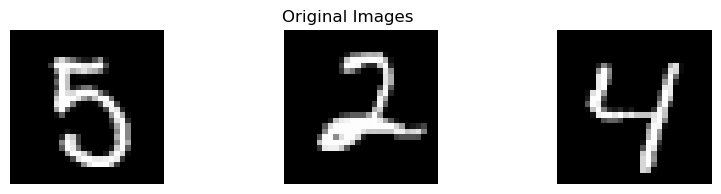

In [26]:
for i, (test_images, test_labels) in enumerate(test_dataloader):
    if i == 2:##
        break
show_images(test_images, test_labels,"Original Images")
file_name = 'originalMNISTimage(524).png'
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()

In [27]:
def ssim_loss(img1, img2):

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    mu1 = F.avg_pool2d(img1, kernel_size=3, stride=1, padding=1)
    mu2 = F.avg_pool2d(img2, kernel_size=3, stride=1, padding=1)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.avg_pool2d(img1 ** 2, kernel_size=3, stride=1, padding=1) - mu1_sq
    sigma2_sq = F.avg_pool2d(img2 ** 2, kernel_size=3, stride=1, padding=1) - mu2_sq
    sigma12 = F.avg_pool2d(img1 * img2, kernel_size=3, stride=1, padding=1) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1)*(2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

EmbeddingDimentions:1 Epoch: 9/10

SSIM: 0.8663471341133118
loss_train: 0.0110,loss_test: 0.0118
MSE: 0.01177297392860055
ProcessingTime: 987.0195007324219


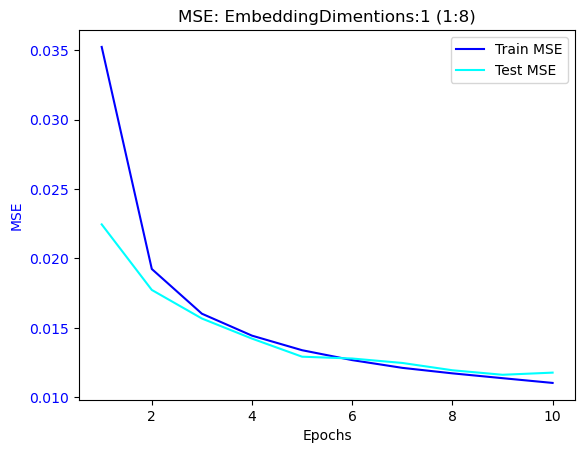

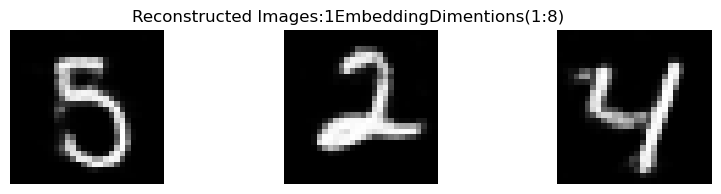

EmbeddingDimentions:2 Epoch: 9/10

SSIM: 0.8100885152816772
loss_train: 0.0151,loss_test: 0.0163
MSE: 0.01631462494842708
ProcessingTime: 980.6478471755981


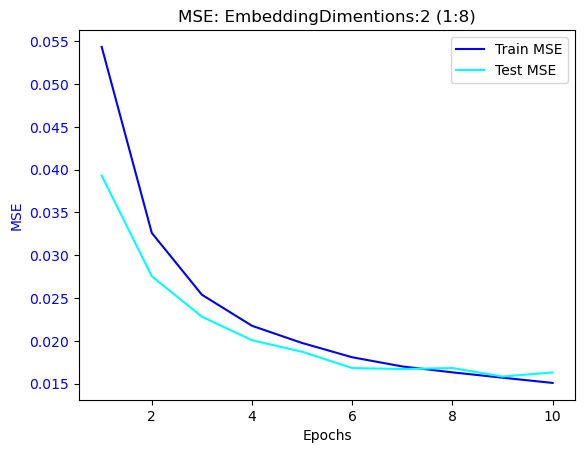

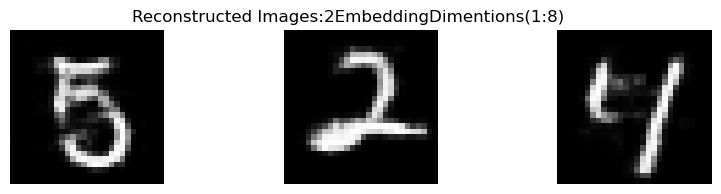

EmbeddingDimentions:3 Epoch: 9/10

SSIM: 0.8265183568000793
loss_train: 0.0131,loss_test: 0.0144
MSE: 0.014375673793256282
ProcessingTime: 982.8321392536163


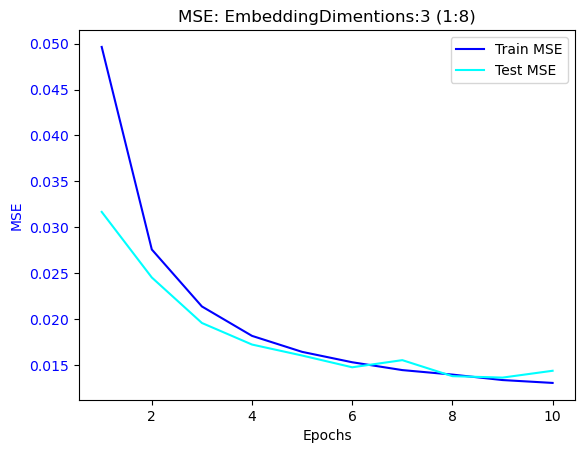

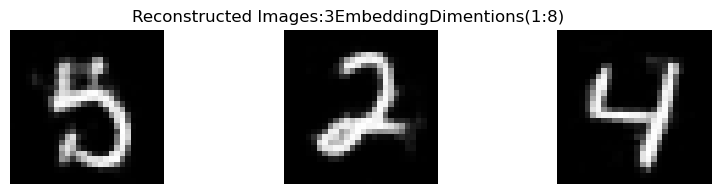

EmbeddingDimentions:4 Epoch: 9/10

SSIM: 0.8241649270057678
loss_train: 0.0139,loss_test: 0.0139
MSE: 0.013919771974906325
ProcessingTime: 988.8103034496307


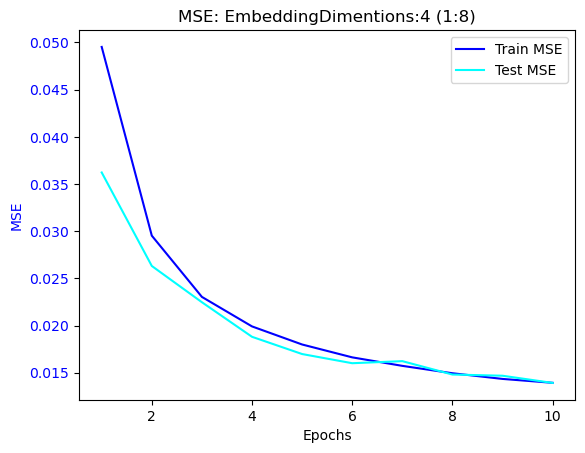

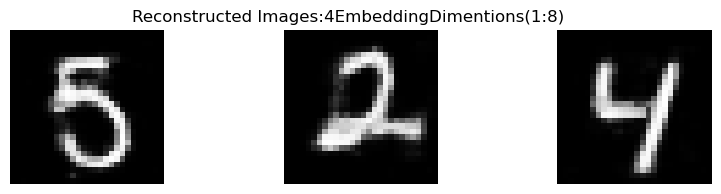

EmbeddingDimentions:5 Epoch: 9/10

SSIM: 0.8631845712661743
loss_train: 0.0102,loss_test: 0.0106
MSE: 0.010591302327811717
ProcessingTime: 989.1133155822754


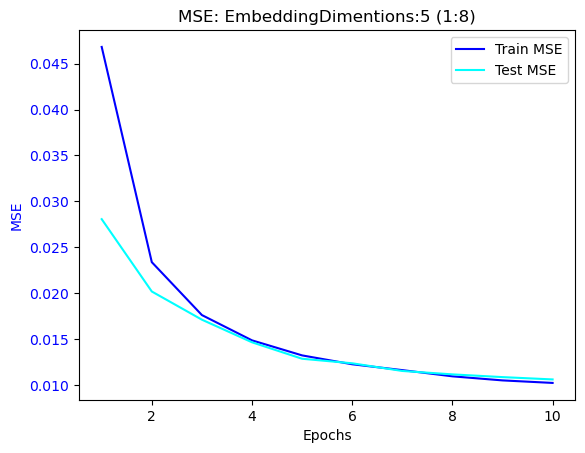

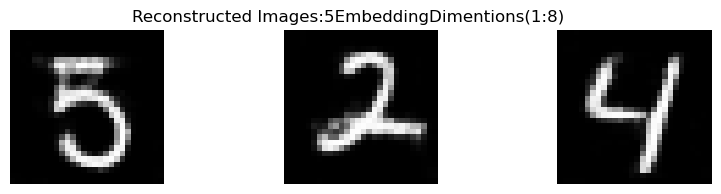

EmbeddingDimentions:6 Epoch: 9/10

SSIM: 0.720312774181366
loss_train: 0.0230,loss_test: 0.0231
MSE: 0.023054926339536905
ProcessingTime: 995.651397228241


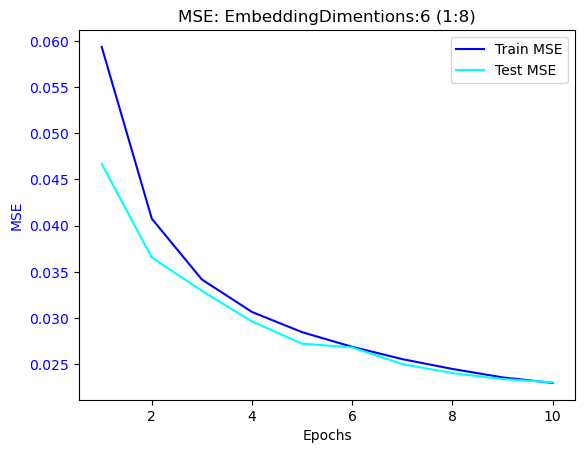

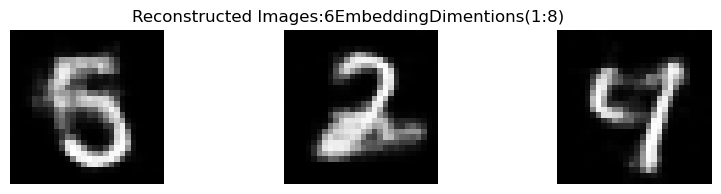

EmbeddingDimentions:7 Epoch: 9/10

SSIM: 0.8603714108467102
loss_train: 0.0109,loss_test: 0.0114
MSE: 0.011387798143550754
ProcessingTime: 997.4257688522339


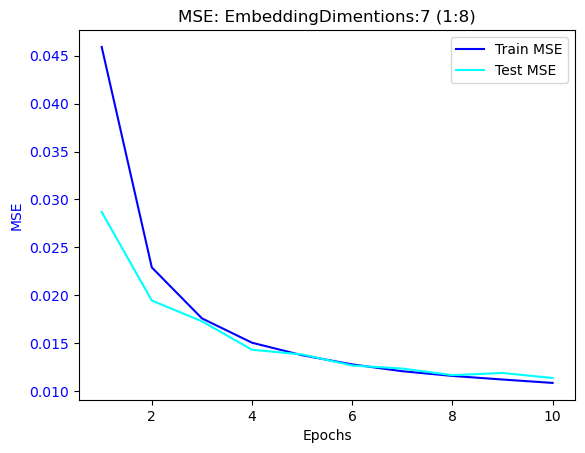

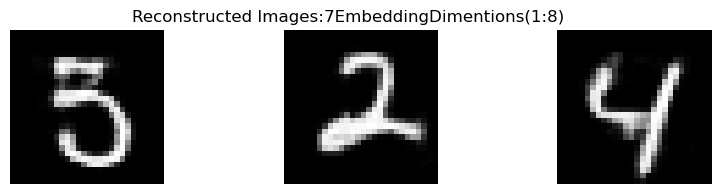

EmbeddingDimentions:8 Epoch: 9/10

SSIM: 0.7990472316741943
loss_train: 0.0158,loss_test: 0.0160
MSE: 0.01600014977157116
ProcessingTime: 1003.649493932724


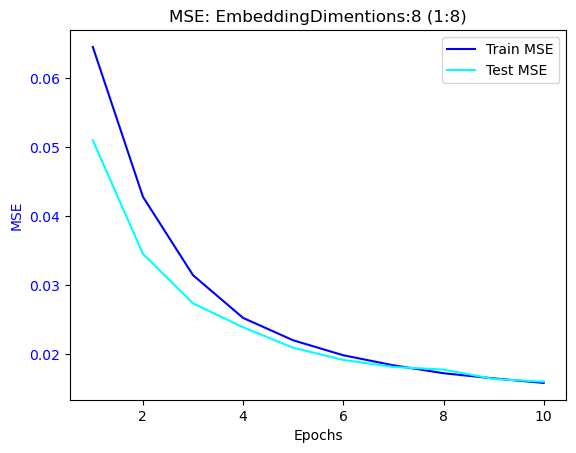

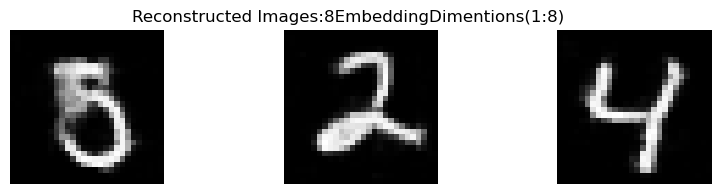

In [28]:
DofIN = 784 ##
leverage = 8 ##圧縮倍率
kernel_size = 4 #カーネルサイズ
ch = 40
EmDim = range(1,9)
max_epochs = 10##


All_last_loss = []
All_last_ssim = []
All_loss_test = []
All_pro_time = []
results = []


num_N = DofIN/leverage


for pos_embed_dim in EmDim: 

    model = AutoEncoder(DofIN,kernel_size,leverage,ch,pos_embed_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    loss_train_ = []
    loss_test_ = []
    pro_time_ = []

            
    for epoch in range(max_epochs):

        sys.stderr.write('\rEmbeddingDimentions:%d Epoch: %d/%d' % (pos_embed_dim, epoch, max_epochs)) 
        sys.stderr.flush()

        loss_train = 0
        loss_test = 0

        start_time1 = time.time()
        for (x,t) in train_dataloader:
                    
            x, t = x.to(device), t.to(device)
            y = model(x).to(device)
            loss = criterion(y, x.view(x.size(0), -1)) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
       
        loss_train_avg = loss_train / len(train_dataloader)
        end_time1 = time.time()
        pro_time_.append(end_time1-start_time1)


        with torch.no_grad():
            for x, t in test_dataloader:
                x, t = x.to(device), t.to(device)
                y = model(x).to(device)
                loss = criterion(y, x.view(x.size(0), -1))
        
                loss_test += loss.item()

        loss_test_avg = loss_test / len(test_dataloader)

        loss_train_.append(loss_train_avg)
        loss_test_.append(loss_test_avg)
        
        if epoch == max_epochs-1:
            All_loss_test.append(loss_test_)
            All_pro_time.append(sum(pro_time_)) 
            ssim_test = ssim_loss(y.view(-1, 1, 28, 28),x.view(-1, 1, 28, 28)).item()
            All_last_ssim.append(ssim_test) 
    Last_loss_test = loss_test_[-1]
    All_last_loss.append(Last_loss_test)
    print('SSIM:',ssim_test)
    print(f"loss_train: {loss_train_avg:.4f},loss_test: {loss_test_avg:.4f}")
    print("MSE:",Last_loss_test)
    print('ProcessingTime:',sum(pro_time_))

    fig, ax1 = plt.subplots()
    ax1.plot(range(1,len(loss_train_)+1), loss_train_, label="Train MSE", color = 'blue')
    ax1.plot(range(1,len(loss_test_)+1), loss_test_, label="Test MSE", color = 'cyan')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MSE', color = 'blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend()

    title = 'MSE: EmbeddingDimentions:%d (1:%d)'%(pos_embed_dim,leverage) #
    plt.title(title)
    file_name = '%d_%dEmDim(1:%d)_ex.png'%(int(formatted_date),pos_embed_dim,leverage)
    full_path = os.path.join(save_directory, file_name)
    plt.savefig(full_path, dpi=100, bbox_inches='tight')
    plt.show()

    with torch.no_grad():
        test_images = test_images.to(device)
        reconstructed_images = model(test_images)
        image_title = "Reconstructed Images:%dEmbeddingDimentions(1:%d)"%(pos_embed_dim,leverage)
        show_images(reconstructed_images.cpu(),test_labels, image_title)
        file_name = '%d_ReImage%dEmDim(1:%d).png'%(int(formatted_date),pos_embed_dim,leverage)
        full_path = os.path.join(save_directory, file_name)
        plt.savefig(full_path, dpi=100, bbox_inches='tight')
        plt.show()




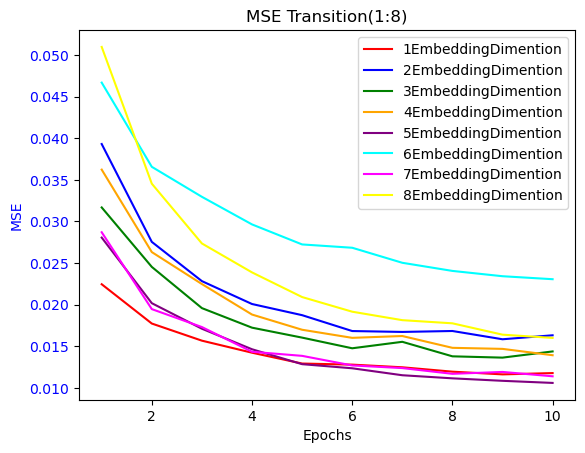

In [29]:
fig, ax1 = plt.subplots()

custom_colors = [
    'red', 'blue', 'green', 'orange', 'purple',
    'cyan', 'magenta', 'yellow', 'brown', 'gray'
]
for idx, loss_test_ in enumerate(All_loss_test):
    ax1.plot(range(1,len(loss_test_)+1), loss_test_, label='%dEmbeddingDimention'%(idx+1), color = custom_colors[idx])

ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE', color = 'blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend()

title = 'MSE Transition(1:%d)'%(leverage) #
plt.title(title)
file_name = '%d_MSEperEpochs.png'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()

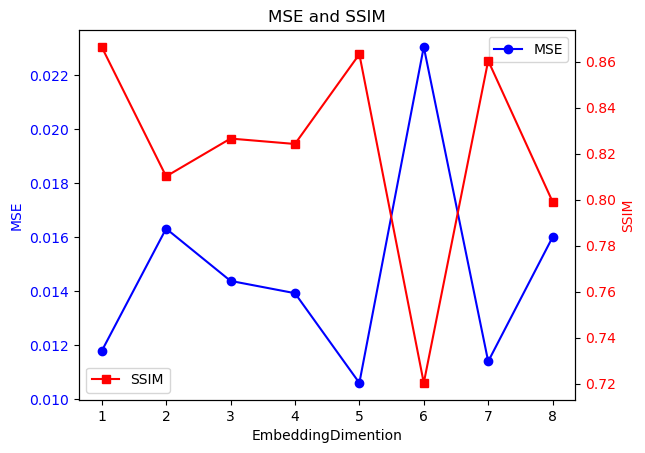

In [30]:

fig,ax1 = plt.subplots()

ax1.plot(EmDim, All_last_loss, 'b-o', label='MSE')
ax1.set_xlabel('EmbeddingDimention')
ax1.set_ylabel('MSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(EmDim, All_last_ssim, 'r-s', label='SSIM')
ax2.set_ylabel('SSIM', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.legend()
ax2.legend()

title = 'MSE and SSIM' #
plt.title(title)
file_name = '%d_MSEandSSIM.png'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()

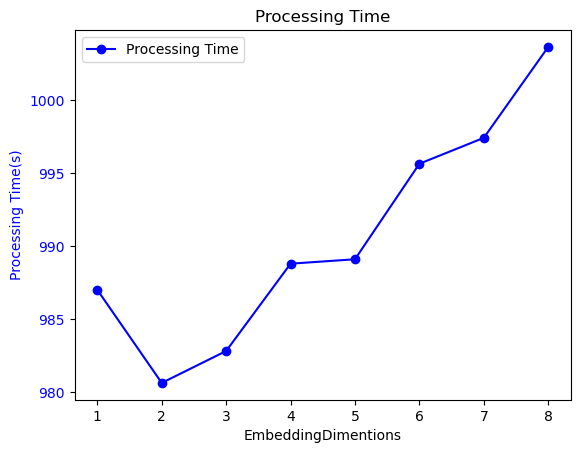

In [31]:
fig,ax1 = plt.subplots()

ax1.plot(EmDim, All_pro_time, 'b-o', label='Processing Time')
ax1.set_xlabel('EmbeddingDimentions')
ax1.set_ylabel('Processing Time(s)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend()

title = 'Processing Time' #
plt.title(title)
file_name = '%d_Protime.png'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()

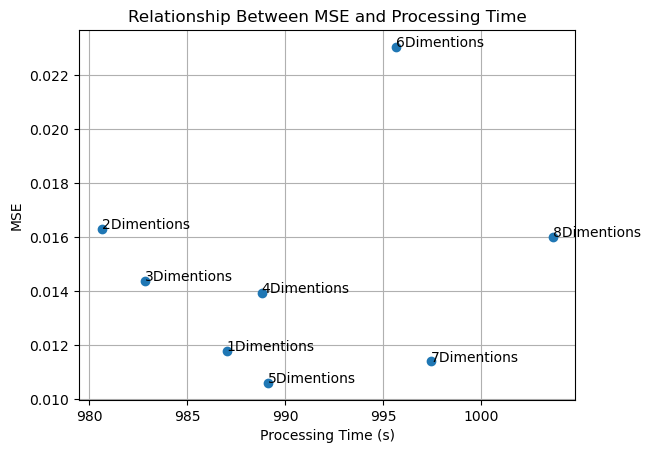

In [32]:
#plt.figure(figsize=(8, 6))
plt.plot(All_pro_time, All_last_loss,'o')
for i in EmDim:
    plt.text(All_pro_time[i-1], All_last_loss[i-1], '%dDimentions'%(i), fontsize=10)

plt.xlabel('Processing Time (s)')
plt.ylabel('MSE')
plt.grid()

title = 'Relationship Between MSE and Processing Time' #
plt.title(title)
file_name = '%d_MSEandTime.png'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()